In [ ]:
import pandas as pd
import talib as ta

def preprocess_data(z_: pd.DataFrame) -> pd.DataFrame:
    """数据预处理：计算收益率、波动率、ATR"""
    z = z_.copy()
    z['ret'] = z['close'].pct_change().fillna(0)
    # 波动率校正后的收益率，夏普比率的变形
    z['rolling_ret'] = z['close'].pct_change(periods=10).fillna(0)  # 滚动计算过去10个周期的ret
    z['rolling_vol'] = z['ret'].rolling(window=10).std().fillna(1e-6)  # 滚动计算过去10个周期的波动率
    z['signal_strength'] = z['rolling_ret'] / z['rolling_vol']
    z['atr'] = ta.ATR(z['high'], z['low'], z['close'], timeperiod=14)
    z['position'] = 0.0
    z['flag'] = 0.0
    return z

def run_strategy(z: pd.DataFrame) -> tuple:
    Buy, Sell = [], []
    max_price = 0
    atr_entry = 0
    price_in = 0

    for i in range(10, len(z)):
        signal = z['signal_strength'][i]

        # ✅ 开仓逻辑：信号强度 > 0.5
        if z['position'][i - 1] == 0 and signal > 0.5:
            z.at[z.index[i], 'flag'] = 1
            z.at[z.index[i], 'position'] = 1
            # TODO open价格开仓的局限性——股票
            price_in = z['close'][i]  # 记录开仓价格
            date_in = z.index[i]  # 记录开仓的时间
            atr_entry = z['atr'][i]
            max_price = z['close'][i]
            Buy.append([date_in, price_in, f'开仓: signal={signal:.2f}, ATR={atr_entry:.2f}'])
            print(z.index[i], f'【开仓】信号={signal:.2f}，ATR={atr_entry:.2f}')

        # ✅ 平仓逻辑（有仓位时）
        elif z['position'][i - 1] == 1:
            current_price = z['close'][i]
            max_price = max(max_price, current_price)
            floating_profit = (current_price - price_in) / price_in
            floating_drawdown = (max_price - current_price) / max_price  # 止盈用
            drawdown_atr = price_in - current_price  # ✅ 用于止损

            # ✅ 止损条件：开仓价 - 当前价 > 2ATR
            if drawdown_atr > 2 * atr_entry:
                z.at[z.index[i], 'flag'] = -1
                z.at[z.index[i], 'position'] = 0
                price_out = z['close'][i]
                date_out = z.index[i]
                Sell.append([date_out, price_out, f'止损: 跌幅={drawdown_atr:.2f} > 2ATR={2*atr_entry:.2f}'])
                print(z.index[i], f'【止损】当前价格较开仓价下跌{drawdown_atr:.2f} > 2ATR')

            # ✅ 止盈条件：从最高浮盈回撤超10%
            # 不跌破40日均线不离场
            # 仓位的逐步增减，盘中动量衰减，平掉1/3的仓位，利润回撤接近最大阈值，那么全平
            elif floating_profit > 0 and floating_drawdown > 0.10: 
                z.at[z.index[i], 'flag'] = -1
                z.at[z.index[i], 'position'] = 0
                price_out = z['close'][i]
                date_out = z.index[i]
                Sell.append([date_out, price_out, f'止盈: 回撤={floating_drawdown:.2%}'])
                print(z.index[i], f'【止盈】浮盈回撤={floating_drawdown:.2%} > 10%')

            else:
                z.at[z.index[i], 'position'] = z['position'][i - 1]
                print(z.index[i], f'持仓中，当前浮盈={floating_profit:.2%}')


    # 交易记录整理
    p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
    p2 = pd.DataFrame(Sell, columns=['卖出日期', '卖出价格', '备注'])
    transaction = pd.concat([p1, p2], axis=1)

    # 净值计算
    z['ret'] = z['close'].pct_change().fillna(0)
    z['nav'] = 1 + (z['ret'] * z['position']).cumsum()  # 单利的计算
    z['benchmark'] = z['close'] / z['close'].iloc[0]

    return z, transaction


In [8]:
import crypto_process
# import puppyV2_strategy
from Stategy import puppyV2_strategy as strategy  # 修改这一行

start_month = '2023-01'
end_month = '2024-09'
freq = '1h'
z_original = crypto_process.load_data(start_month,end_month)
z_resampled = crypto_process.resample_data(z_original,freq)

# z = puppy_strategy.preprocess_data(z_resampled)
# data_price,transaction = puppy_strategy.run_strategy(z) 

data_price,transaction = strategy.execute_strategy(z_resampled)



成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2023-01.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44640, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2023-02.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (40320, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2023-03.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44560, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2023-04.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (43200, 12)
成功读取文件: D:/workspace/data/crypto

d:\Project\miniConda\lessonOne\第二课：规则类课程\规则类课程\Stategy\puppyV2_strategy.py:39: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["ret"] = z["close"].pct_change().fillna(0)
d:\Project\miniConda\lessonOne\第二课：规则类课程\规则类课程\Stategy\puppyV2_strategy.py:40: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["rolling_ret"] = z["close"].pct_change(periods=ret_periods).fillna(0)


2023-01-11 23:00:00 【V2开仓】z=1.00, 价格=17943.26, 初始止损=17755.92
2023-01-12 05:00:00 【V2平仓】止损，价格=18087.54
2023-01-13 15:00:00 【V2开仓】z=1.18, 价格=19261.19, 初始止损=18932.64
2023-01-14 09:00:00 【V2平仓】止损，价格=20523.75
2023-01-20 20:00:00 【V2开仓】z=0.97, 价格=22288.37, 初始止损=21909.28
2023-01-21 10:00:00 【V2平仓】止损，价格=22777.52
2023-01-29 18:00:00 【V2开仓】z=2.29, 价格=23678.99, 初始止损=23385.04
2023-01-30 08:00:00 【V2平仓】止损，价格=23548.76
2023-02-02 00:00:00 【V2开仓】z=2.12, 价格=24189.85, 初始止损=23776.03
2023-02-02 06:00:00 【V2平仓】止损，价格=23786.46
2023-02-16 00:00:00 【V2开仓】z=2.90, 价格=24583.17, 初始止损=24051.29
2023-02-16 14:00:00 【V2平仓】止损，价格=24423.80
2023-03-14 12:00:00 【V2开仓】z=2.14, 价格=25832.57, 初始止损=25044.34
2023-03-14 18:00:00 【V2平仓】止损，价格=24990.18
2023-03-17 01:00:00 【V2开仓】z=1.12, 价格=25666.59, 初始止损=25053.54
2023-03-18 22:00:00 【V2平仓】止损，价格=26910.45


d:\Project\miniConda\lessonOne\第二课：规则类课程\规则类课程\Stategy\puppyV2_strategy.py:169: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["ret"] = z["close"].pct_change().fillna(0)


<Axes: xlabel='open_time'>

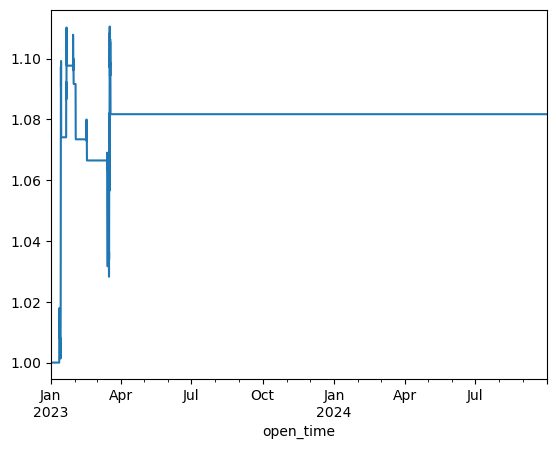

In [9]:
data_price.nav.plot()

In [ ]:
def calculate_performance_metrics(data_price:pd.DataFrame,transactions:pd.DataFrame) -> pd.DataFrame:
    '''计算绩效指标'''
    N = 365  # 一年的交易天数,国内的期货和股票都是252个交易日左右，加密货币365天
    rf = 0.02 # risk free rate，无风险收益率

    # 年化收益率
    rety = data_price.nav.iloc[-1]**(N/data_price.shape[0]) - 1

    # ========================重点2===========================
    # 夏普比率
    strategy_returns = data_price.ret * data_price.position  # 下一节课详细讲解
    # 记住年化夏普比率的公式
    sharpe = (strategy_returns.mean() * N - rf) / (strategy_returns.std() * np.sqrt(N))

    # 胜率
    VictoryRatio = ((transactions['卖出价格'] - transactions['买入价格']) > 0).mean()

    # 最大回撤
    DD = 1 - data_price.nav / data_price.nav.cummax()  # drawdown
    MDD = DD.max()  # maximum drawdown

    # 月均交易次数
    trade_count = data_price.flag.abs().sum() / data_price.shape[0] * 20

    # 将结果整理成字典
    result = {
        'Sharpe': sharpe, # 夏普比率
        'Annual_Return': rety, # 年化收益率
        'MDD': MDD,  # 最大回撤
        'Winning_Rate': VictoryRatio,  # 胜率
        'Trading_Num': round(trade_count, 1) # 月均交易次数
    }
    
    return pd.DataFrame(result, index=[0])


In [ ]:
result = calculate_performance_metrics(data_price,transaction)

In [ ]:
result

In [ ]:
flag = z['flag']

In [ ]:
price_ = z[['close','high','low','open']]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(z.index, z['close'], label='Close')

# 标记开仓和平仓点
ax.scatter(z[z['flag'] == 1].index, z[z['flag'] == 1]['close'], marker='^', color='red', label='Buy', s=100)
ax.scatter(z[z['flag'] == -1].index, z[z['flag'] == -1]['close'], marker='v', color='green', label='Sell', s=100)

ax.legend()
plt.title("trading signal")
plt.grid(True)
plt.show()


In [ ]:
# 1.掌握事件触发回测框架
# 2.理解复利和单利的区别